## **演练0603：卷积神经网络的实现**

### **案例1：cnn的快速计算模块**
* 原始的CNN算法计算速度较慢，而CNN网络规模一般较大，因此非常耗时。斯坦福大学CS231N课程提供了一个快速计算模块。包括下列文件：
 * 【fast_layers.py】：这是主要的接口文件，供CNN网络调用以执行前向计算和反向传播梯度计算
 * 【im2col.py】【im2col_cython.pyx】：底层实现
 * 【setup.py】：编译文件
* 编译方法
 * Windows下，要安装Visual C++ 2017版本，以确保存在C++的编译器；
 * Ubuntu下：sudo apt-get install build-essentials
 * 安装好Python3及Pip3
 * 安装Cython： pip3 install Cython
 * 进入代码文件所在目录，执行：python setup.py build_ext --inplace
   * 将会生成im2col_cython.c，并编译成本地的库
   * 请注意，如果目录下已经存在im2col_cython.c，请先删除之，在运行setup

### **案例2：对比fastcnn和原始cnn计算的效率**

* 本例使用了【util_common_layer.py】【util_conv_layer.py】【fast_layer.py】等代码文件
* 【util_conv_layer.py】中定义了conv_forward_naive和conv_forward_fast方法进行前向计算；conv_backward_naive和conv_backward_fast方法进行反向传播计算
* 【util_conv_layer.py】中定义了max_pool_forward_naive和max_pool_forward_fast方法进行前向计算；max_pool_backward_naive和max_pool_backward_fast方法进行反向传播计算
* fastcnn的速度是原始cnn实现的100倍以上

> **步骤1：卷积层的前向和反向计算时间对比**

In [2]:
import numpy as np
import util_common_layer
from util_conv_layer import *

def rel_error(x, y):
  """ 计算相对误差 """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 【1】对比fast_layers和naive对conv_forward和conv_backward的实现 ============<
from fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(100)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))
# 【1】对比fast_layers和naive对conv_forward和conv_backward的实现 ==========>

Testing conv_forward_fast:
Naive: 3.304561s
Fast: 0.020622s
Speedup: 160.240644x
Difference:  3.547960195902893e-09

Testing conv_backward_fast:
Naive: 5.001264s
Fast: 0.009904s
Speedup: 504.954528x
dx difference:  2.067506142060277e-11
dw difference:  8.384074490158895e-13
db difference:  1.6325508882288134e-14


> **步骤2：池化层的前向和反向计算时间对比**

In [10]:
# 【2】对比fast_layers和naive对max_pool_forward和max_pool_backward的实现 <=============================================
from fast_layers import max_pool_forward_fast, max_pool_backward_fast
from time import time
np.random.seed(100)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
# 【2】对比fast_layers和naive对max_pool_forward和max_pool_backward的实现 =========>

Testing pool_forward_fast:
Naive: 0.265304s
fast: 0.001473s
speedup: 180.088526x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.793514s
speedup: 111.063470x
dx difference:  0.0


### **示例3：构造一个基本的CNN网络执行CIFAR-10图像分类**  
* 必须按照案例1中的步骤，编译和安装fast_layer模块
* 使用的代码包括【util_common_layer.py】【util_conv_layer.py】【fast_layer.py】【cnn.py】【util_data.py】【solver.py】【optim.py】
* 网络结构为：conv - relu - 2x2 max pool - affine - relu - affine - softmax
* 选取100个样本试算，观察loss下降情况，以确保网络初步计算的合理性   
![](../images/160301.png)  
* 计算完整的计算，大约训练集:0.459，验证集：0.476。如果要进一步提升性能，需要更精细的设计卷积神经网络的结构

> **步骤1：小样本试算**

========== 数据装载和预处理 ==========
训练数据:  (49000, 3, 32, 32)
验证数据:  (1000, 3, 32, 32)
测试数据:  (1000, 3, 32, 32)
========== 数据装载和预处理完成 ======
(Iteration 1 / 30) loss: 2.472426
(Epoch 0 / 15) train acc: 0.260000; val_acc: 0.157000
(Iteration 2 / 30) loss: 2.128848
(Epoch 1 / 15) train acc: 0.210000; val_acc: 0.097000
(Iteration 3 / 30) loss: 2.569820
(Iteration 4 / 30) loss: 1.859039
(Epoch 2 / 15) train acc: 0.410000; val_acc: 0.187000
(Iteration 5 / 30) loss: 1.926493
(Iteration 6 / 30) loss: 1.504407
(Epoch 3 / 15) train acc: 0.560000; val_acc: 0.186000
(Iteration 7 / 30) loss: 1.315861
(Iteration 8 / 30) loss: 1.410171
(Epoch 4 / 15) train acc: 0.620000; val_acc: 0.177000
(Iteration 9 / 30) loss: 0.921790
(Iteration 10 / 30) loss: 1.004382
(Epoch 5 / 15) train acc: 0.750000; val_acc: 0.207000
(Iteration 11 / 30) loss: 0.824603
(Iteration 12 / 30) loss: 0.702915
(Epoch 6 / 15) train acc: 0.800000; val_acc: 0.202000
(Iteration 13 / 30) loss: 0.632647
(Iteration 14 / 30) loss: 0.530349
(Epoc

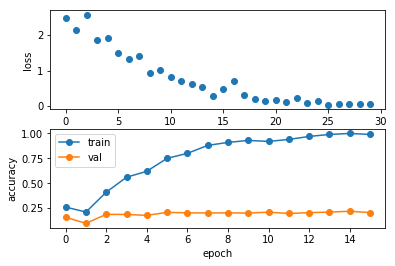

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import util_common_layer
import util_data
from cnn import ThreeLayerConvNet
from solver import Solver
from optim import *

def rel_error(x, y):
  """ 计算相对误差 """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 装载数据
print("========== 数据装载和预处理 ==========")
cifar10_dir = '../dataset/cifar-10'
data_list = util_data.load_and_preprocess_cifar10(cifar10_dir)
X_train = data_list['X_train']
y_train = data_list['y_train']
X_val = data_list['X_val']
y_val = data_list['y_val']
X_test = data_list['X_test']
y_test = data_list['y_test']

mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# 检查数据维度
print('训练数据: ', X_train.shape)
print('验证数据: ', X_val.shape)
print('测试数据: ', X_test.shape)
print("========== 数据装载和预处理完成 ======")


# 【1】检验少量数据的overfit =================<
np.random.seed(100)

num_train = 100
small_data = {
  'X_train': data_list['X_train'][:num_train],
  'y_train': data_list['y_train'][:num_train],
  'X_val': data_list['X_val'],
  'y_val': data_list['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)
solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
# 【1】检验少量数据的overfit =====================>

> **步骤2：完整数据集训练**
* 正确率：训练集约0.459，验证集约0.476。如果要进一步提升性能，需要更精细的设计卷积神经网络的结构

In [4]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data_list,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train() # 训练集:0.459，验证集：0.476

(Iteration 1 / 980) loss: 2.304363
(Epoch 0 / 1) train acc: 0.105000; val_acc: 0.119000
(Iteration 21 / 980) loss: 2.314155
(Iteration 41 / 980) loss: 2.158747
(Iteration 61 / 980) loss: 1.951404
(Iteration 81 / 980) loss: 1.827451
(Iteration 101 / 980) loss: 1.812707
(Iteration 121 / 980) loss: 1.977814
(Iteration 141 / 980) loss: 1.730302
(Iteration 161 / 980) loss: 1.664499
(Iteration 181 / 980) loss: 1.916465
(Iteration 201 / 980) loss: 1.733001
(Iteration 221 / 980) loss: 2.089367
(Iteration 241 / 980) loss: 1.787464
(Iteration 261 / 980) loss: 1.471218
(Iteration 281 / 980) loss: 1.656120
(Iteration 301 / 980) loss: 1.528704
(Iteration 321 / 980) loss: 1.764497
(Iteration 341 / 980) loss: 1.783352
(Iteration 361 / 980) loss: 1.548030
(Iteration 381 / 980) loss: 1.829693
(Iteration 401 / 980) loss: 1.595263
(Iteration 421 / 980) loss: 1.572968
(Iteration 441 / 980) loss: 1.676411
(Iteration 461 / 980) loss: 1.652522
(Iteration 481 / 980) loss: 1.764205
(Iteration 501 / 980) loss: 